<a href="https://colab.research.google.com/github/NicolasChagnet/pokemon-team-optimization/blob/main/TeamOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokemon Team Optimization

The goal of this notebook is to find an optimal Pokemon team using the [Pokemon dataset](https://www.kaggle.com/datasets/rounakbanik/pokemon) and the Pulp package of solvers for optimization problems.

The problem is defined by the following constraints:
- A team must have up to 6 Pokemon in total.
- The coverage of the team should be maximized.
- The weaknesses of the team should be minimized.
- The base total (sum of all stats of each Pokemon) should be maximized.

Eventually, the final team will be further constrained to have:
- No legendaries or pseudo-legendaries.
- No dragon Pokemon (they tend to make things a bit too easy).
- At most 1 starter Pokemon.

## Initializations

In [38]:
%cd /content/drive/MyDrive/Colab\ Notebooks
# !git clone https://github.com/NicolasChagnet/pokemon-team-optimization.git
%cd pokemon-team-optimization
!git pull

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/pokemon-team-optimization
Already up to date.


In [67]:
# Download dependencies
!pip install pandas numpy matplotlib seaborn pulp pokebase

In [85]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
import os
import pulp
import pokebase
from IPython.display import Image
import ipywidgets as widgets
from IPython.display import HTML

Let us start by loading the Pokemon data. An important note: the columns "against_XXX" denote the damage factor taken by the Pokemon against an attack of that type.

In [41]:
GENERATION_CAP = 4
NTYPES = 18
pks = pd.read_csv("data/pokemon.csv")
# Drop the Pokemons above the Generation cap and columns we will not use
pks = pks.drop(pks.loc[pks["generation"] > GENERATION_CAP].index)
pks = pks.drop(['abilities', 'attack',
       'base_egg_steps', 'base_happiness',  'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name',  'percentage_male',
       'sp_attack', 'sp_defense', 'speed',  'weight_kg'], axis=1)
pks["name"] = pks["name"].str.lower()

In [59]:
# This will be useful for later
list_starters_final_stage = [
  "venusaur",
  "charizard",
  "blastoise",
  "typhlosion",
  "meganium",
  "feraligatr",
  "swampert",
  "blaziken",
  "sceptile",
  "torterra",
  "infernape",
  "empoleon",
  "serperior",
  "emboar",
  "samurott",
  "chesnaught",
  "delphox",
  "greninja",
  "decidueye",
  "incineroar",
  "primarina",
  "rillaboom",
  "cinderace",
  "inteleon",
  "meowscarada",
  "skeledirge",
  "quaquaval"
]
pks["starter"] = pks["name"].isin(list_starters_final_stage).astype(int)

In [60]:
display(pks.columns)
type_columns = [col for col in pks.columns if "against" in col]
pks.head()

Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'against_poison', 'against_psychic', 'against_rock',
       'against_steel', 'against_water', 'base_total', 'name',
       'pokedex_number', 'type1', 'type2', 'generation', 'is_legendary',
       'starter'],
      dtype='object')

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,against_steel,against_water,base_total,name,pokedex_number,type1,type2,generation,is_legendary,starter
0,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,0.5,318,bulbasaur,1,grass,poison,1,0,0
1,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,0.5,405,ivysaur,2,grass,poison,1,0,0
2,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,0.5,625,venusaur,3,grass,poison,1,0,1
3,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,0.5,2.0,309,charmander,4,fire,NaN,1,0,0
4,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,0.5,2.0,405,charmeleon,5,fire,NaN,1,0,0


In [94]:
def display_team(team):
  style = "<style>#output-body{display:flex; flex-direction: row;}</style>"
  style_none = "<style>#output-body{display:none; flex-direction: none;}</style>"
  display(HTML(style))
  for pkm in team["name"].values:
    display(Image(pokebase.pokemon(pkm).sprites.front_default))


## Optimization problem

Let us start with the first part of the optimization problem using the dataset as it is. We can denote by $x_i$ whether a Pokemon is in the team or not, which means that the constraint of having a full team is $\sum_i x_i = 6$.

Furthermore, denoting by $b_i$ the base total of the Pokemon $i$, maximizing the base state means finding $x_i = \arg \max_{x_i} x_i b_i$ under the previous constraint.

Finally, we want to reduce the weaknesses of our team. We can denote the damage multiple for the Pokemon $i$ against the type $A$ as $w_{iA}$. We want to ensure there is at least one resistant Pokemon to every type i.e. for every $A \in [1, 18]$, we want to impose $\min x_i w_{i A} \leq 1.0$.

Note that such minimizations are difficult to add with PulP. The trick explained [here](https://stackoverflow.com/questions/51939363/pulp-milp-constraint-at-least-one-variable-must-be-below-0) is to define extra boolean variables $y_{A i}$ such that for all $i,A$, we impose $x_i w_{i A} \leq 1.0 + m*(1-y_{Ai})$ and $\sum_i y_{Ai} \geq 1$. The last constraint means that for each $A$, there must be one $i$ with $y_{Ai} = 1$. For $m$ sufficiently large, $y_{Ai} = 0$ for the others is not a constraint.

In [76]:
def present_solution_weaknesses(team, types):
  team_by_name = team.set_index("name")
  team_by_types = team_by_name[types].transpose()
  team_by_types["min_val"] = team_by_types.min(axis=1)
  team_by_types["min_pkmn"] = team_by_types.idxmin(axis=1)
  team_by_types["type1"] = team_by_name.loc[team_by_types["min_pkmn"].values, "type1"].values
  team_by_types["type2"] = team_by_name.loc[team_by_types["min_pkmn"].values, "type2"].values
  return team_by_types

def optimize_team_weakness(pkms, types, size_team=6):
  prob = pulp.LpProblem("Pokemon_Team_Optimization", pulp.LpMaximize)

  # Define the boolean variables
  x = pulp.LpVariable.dicts("x", range(len(pkms)), cat='Binary')
  y = pulp.LpVariable.dicts("y", (range(len(types)), range(len(pkms))), cat='Binary')

  # Define the size constraint
  prob += pulp.lpSum(x[i] for i in range(len(pkms))) == size_team, "Team Size"

  # Define the base total sum
  prob += pulp.lpSum(pkmn["base_total"] * x[i] for i, pkmn in pkms.iterrows()), "Maximal base total"

  # Define the weakness sum bound for each type
  # Based on https://stackoverflow.com/questions/51939363/pulp-milp-constraint-at-least-one-variable-must-be-below-0
  m=100
  for a,type_col in enumerate(types):
    prob += pulp.lpSum(y[a][i] for i in range(len(pkms))) >= 1 # Overall constraint for each type
    for i, pkmn in pkms.iterrows():
      prob += x[i] * pkmn[type_col]  <= 0.5 + m*(1-y[a][i]), f"Weakness {type_col} for pokemon {i}"

  out_code = prob.solve()
  display(print(f"Out code: {out_code}"))

  if out_code == 1:
    idxs_sol = [i for i in range(len(pkms)) if pulp.value(x[i]) == 1]
    pkms_selected = pkms.loc[idxs_sol]
    return pkms_selected
  return None

In [99]:
pkmns_weakness = optimize_team_weakness(pks, type_columns)

Out code: 1


None

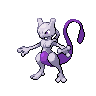

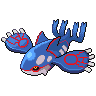

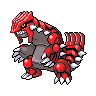

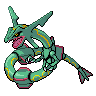

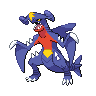

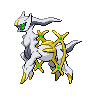

In [104]:
display_team(pkmns_weakness)

In [96]:
display(pkmns_weakness[["name","type1","type2"]])
display(present_solution_weaknesses(pkmns_weakness, type_columns)[["min_val", "min_pkmn", "type1", "type2"]])

Out code: 1


None

,name,type1,type2
149,mewtwo,psychic,NaN
381,kyogre,water,NaN
382,groudon,ground,NaN
383,rayquaza,dragon,flying
444,garchomp,dragon,ground
492,arceus,normal,NaN


name,min_val,min_pkmn,type1,type2
against_bug,0.50,rayquaza,dragon,flying
against_dark,1.00,kyogre,water,NaN
against_dragon,1.00,mewtwo,psychic,NaN
against_electric,0.00,groudon,ground,NaN
against_fairy,1.00,mewtwo,psychic,NaN
against_fight,0.50,mewtwo,psychic,NaN
against_fire,0.50,kyogre,water,NaN
against_flying,1.00,mewtwo,psychic,NaN
against_ghost,0.00,arceus,normal,NaN
against_grass,0.25,rayquaza,dragon,flying


We see an issue here: some weaknesses are still at least equal to 1.

The constraint to have one $y_{Ai} = 1$ for all $A$ does not mean these coincide with the Pokemon selected for the team. So we need more variables. The idea is to create variables $z_{Ai}$ under the constraint:
$$
\begin{aligned}
  z_{Ai} \leq x_i~,\\
  z_{Ai} \leq y_{Ai}~,\\
  z_{Ai} \geq x_i + y_{Ai} - 1~.
\end{aligned}
$$
More can be found [here](https://stackoverflow.com/questions/31173983/python-pulp-integer-linear-program-with-dynamic-constraint). For a given $A$ and $i$, we see that if $x_i = y_{Ai} = 1$, then $z_{Ai} = 1$. Otherwise, if one of them is $0$, the first two constraints impose that $z_{Ai} = 0$.

Finally, the constraint $\sum_i y_{Ai} \geq 1$ should be changed to $\sum_i z_{Ai} \geq 1$ to impose that **both** $y_{Ai}$ and $x_i$ are equal to 1 for some $i$, for every $A$.

In [102]:
def optimize_team_weakness_improved(pkms, types, size_team=6):
  prob = pulp.LpProblem("Pokemon_Team_Optimization", pulp.LpMaximize)

  # Define the boolean variables
  x = pulp.LpVariable.dicts("x", range(len(pkms)), cat='Binary')
  y = pulp.LpVariable.dicts("y", (range(len(types)), range(len(pkms))), cat='Binary')
  z = pulp.LpVariable.dicts("z", (range(len(types)), range(len(pkms))), cat='Binary')

  # Define the size constraint
  prob += pulp.lpSum(x[i] for i in range(len(pkms))) == size_team, "Team Size"

  # Define the base total sum
  prob += pulp.lpSum(pkmn["base_total"] * x[i] for i, pkmn in pkms.iterrows()), "Maximal base total"

  # Define the weakness sum bound for each type
  # Based on https://stackoverflow.com/questions/51939363/pulp-milp-constraint-at-least-one-variable-must-be-below-0
  m=100
  for a,type_col in enumerate(types):
    prob += pulp.lpSum(z[a][i] for i in range(len(pkms))) >= 1 # Overall constraint for each type
    for i, pkmn in pkms.iterrows():
      prob += z[a][i] <= x[i], f"Contraint z 1 for {a},{i}"
      prob += z[a][i] <= y[a][i], f"Contraint z 2 for {a},{i}"
      prob += z[a][i] >= x[i] + y[a][i] - 1, f"Contraint z 3 for {a},{i}"
      prob += x[i] * pkmn[type_col]  <= 0.5 + m*(1-y[a][i]), f"Weakness {type_col} for pokemon {i}"

  out_code = prob.solve()
  display(print(f"Out code: {out_code}"))

  if out_code == 1:
    idxs_sol = [i for i in range(len(pkms)) if pulp.value(x[i]) == 1]
    pkms_selected = pkms.loc[idxs_sol]
    return pkms_selected
  return None

In [103]:
pkmns_weakness_optimized = optimize_team_weakness_improved(pks, type_columns)

Out code: 1


None

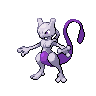

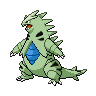

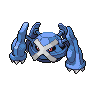

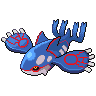

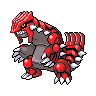

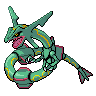

In [106]:
display_team(pkmns_weakness_optimized)

In [101]:
display(pkmns_weakness_optimized[["name","type1","type2"]])
display(present_solution_weaknesses(pkmns_weakness_optimized, type_columns)[["min_val", "min_pkmn", "type1", "type2"]])

Out code: 1


None

,name,type1,type2
149,mewtwo,psychic,NaN
247,tyranitar,rock,dark
375,metagross,steel,psychic
381,kyogre,water,NaN
382,groudon,ground,NaN
383,rayquaza,dragon,flying


name,min_val,min_pkmn,type1,type2
against_bug,0.50,rayquaza,dragon,flying
against_dark,0.50,tyranitar,rock,dark
against_dragon,0.50,metagross,steel,psychic
against_electric,0.00,groudon,ground,NaN
against_fairy,0.50,metagross,steel,psychic
against_fight,0.50,mewtwo,psychic,NaN
against_fire,0.50,tyranitar,rock,dark
against_flying,0.50,tyranitar,rock,dark
against_ghost,0.50,tyranitar,rock,dark
against_grass,0.25,rayquaza,dragon,flying


Finally we found a method which works! All types are covered in our team! However, as expected, the team is full of legendary and pseudo-legendaries. The base total requirement almost ensures this, so let's try to just remove legendaries from the dataset.

In [109]:
pks_no_legendaries = pks.loc[pks["is_legendary"] == 0].reset_index().drop(columns=["index"])
pkmns_weakness_optimized_nolegendaries = optimize_team_weakness_improved(pks_no_legendaries, type_columns)

Out code: 1


None

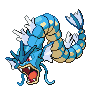

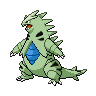

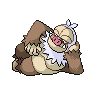

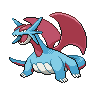

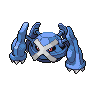

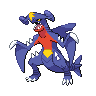

In [110]:
display_team(pkmns_weakness_optimized_nolegendaries)

In [111]:
display(pkmns_weakness_optimized_nolegendaries[["name","type1","type2"]])
display(present_solution_weaknesses(pkmns_weakness_optimized_nolegendaries, type_columns)[["min_val", "min_pkmn", "type1", "type2"]])

,name,type1,type2
129,gyarados,water,flying
239,tyranitar,rock,dark
277,slaking,normal,NaN
361,salamence,dragon,flying
364,metagross,steel,psychic
423,garchomp,dragon,ground


name,min_val,min_pkmn,type1,type2
against_bug,0.50,gyarados,water,flying
against_dark,0.50,tyranitar,rock,dark
against_dragon,0.50,metagross,steel,psychic
against_electric,0.00,garchomp,dragon,ground
against_fairy,0.50,metagross,steel,psychic
against_fight,0.50,gyarados,water,flying
against_fire,0.50,gyarados,water,flying
against_flying,0.50,tyranitar,rock,dark
against_ghost,0.00,slaking,normal,NaN
against_grass,0.25,salamence,dragon,flying


This is great, but again now the team is as expected dominated by dragons because they have the most resistance! It would be interesting to restrict ourselves to non-dragons.

In [112]:
pks_no_legendaries_no_dragons = pks_no_legendaries.loc[(pks_no_legendaries["type1"] != "dragon") & (pks_no_legendaries["type2"] != "dragon")].reset_index().drop(columns=["index"])
pkmns_weakness_optimized_nolegendaries_nodragons = optimize_team_weakness_improved(pks_no_legendaries_no_dragons, type_columns)

Out code: 1


None

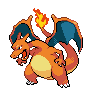

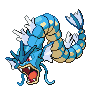

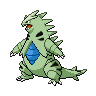

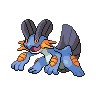

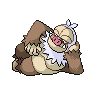

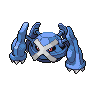

In [113]:
display_team(pkmns_weakness_optimized_nolegendaries_nodragons)

In [114]:
display(pkmns_weakness_optimized_nolegendaries_nodragons[["name","type1","type2"]])
display(present_solution_weaknesses(pkmns_weakness_optimized_nolegendaries_nodragons, type_columns)[["min_val", "min_pkmn", "type1", "type2"]])

,name,type1,type2
5,charizard,fire,flying
129,gyarados,water,flying
235,tyranitar,rock,dark
244,swampert,water,ground
273,slaking,normal,NaN
354,metagross,steel,psychic


name,min_val,min_pkmn,type1,type2
against_bug,0.25,charizard,fire,flying
against_dark,0.50,tyranitar,rock,dark
against_dragon,0.50,metagross,steel,psychic
against_electric,0.00,swampert,water,ground
against_fairy,0.50,charizard,fire,flying
against_fight,0.50,charizard,fire,flying
against_fire,0.50,charizard,fire,flying
against_flying,0.50,tyranitar,rock,dark
against_ghost,0.00,slaking,normal,NaN
against_grass,0.25,charizard,fire,flying


Another restriction we can self-impose is about pseudo-legendaries: those Pokemons appearing each generation with a much higher base total than usual Pokemons. In that sense they are closer to legendaries. But the issue is they usually can only be obtained late in the game (usually close to the last badge if not later). In any game, you would ideally want to get your dream team as early as possible. So let's remove these Pokemons.

In [115]:
list_pseudo_legendaries = [
    "Dragonite",
    "Tyranitar",
    "Salamence",
    "Metagross",
    "Garchomp",
    "Hydreigon",
    "Goodra",
    "Kommo-o",
    "Dragapult",
    "Hisuian Goodra",
    "Baxcalibur"
]
list_pseudo_legendaries = [pkmn.lower() for pkmn in list_pseudo_legendaries]
pks_no_legendaries_no_dragons_no_pl = pks_no_legendaries_no_dragons.loc[-pks_no_legendaries_no_dragons["name"].isin(list_pseudo_legendaries)].reset_index().drop(columns=["index"])
pkmns_weakness_optimized_nolegendaries_nodragons_nopl = optimize_team_weakness_improved(pks_no_legendaries_no_dragons_no_pl, type_columns)

Out code: 1


None

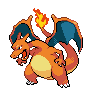

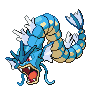

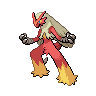

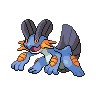

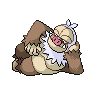

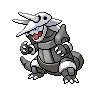

In [116]:
display_team(pkmns_weakness_optimized_nolegendaries_nodragons_nopl)

In [117]:
display(pkmns_weakness_optimized_nolegendaries_nodragons_nopl[["name","type1","type2"]])
display(present_solution_weaknesses(pkmns_weakness_optimized_nolegendaries_nodragons_nopl, type_columns)[["min_val", "min_pkmn", "type1", "type2"]])

,name,type1,type2
5,charizard,fire,flying
129,gyarados,water,flying
240,blaziken,fire,fighting
243,swampert,water,ground
272,slaking,normal,NaN
289,aggron,steel,rock


name,min_val,min_pkmn,type1,type2
against_bug,0.25,charizard,fire,flying
against_dark,0.50,blaziken,fire,fighting
against_dragon,0.50,aggron,steel,rock
against_electric,0.00,swampert,water,ground
against_fairy,0.50,charizard,fire,flying
against_fight,0.50,charizard,fire,flying
against_fire,0.50,charizard,fire,flying
against_flying,0.25,aggron,steel,rock
against_ghost,0.00,slaking,normal,NaN
against_grass,0.25,charizard,fire,flying


This is better, but again there is an issue: there are 3 starters in this team only. It is unrealistic in a game to have more than one starter. To remedy this issue, we will add an extra constraint that there should only be at most one starter.

In [118]:
def optimize_team_weakness_improved_starter_cst(pkms, types, size_team=6):
  prob = pulp.LpProblem("Pokemon_Team_Optimization", pulp.LpMaximize)

  # Define the boolean variables
  x = pulp.LpVariable.dicts("x", range(len(pkms)), cat='Binary')
  y = pulp.LpVariable.dicts("y", (range(len(types)), range(len(pkms))), cat='Binary')
  z = pulp.LpVariable.dicts("z", (range(len(types)), range(len(pkms))), cat='Binary')

  # Define the size constraint
  prob += pulp.lpSum(x[i] for i in range(len(pkms))) == size_team, "Team Size"

  # Starter constraint
  prob += pulp.lpSum(x[i]*pkmn["starter"] for i, pkmn in pkms.iterrows()) <= 1, "Number starter"

  # Define the base total sum
  prob += pulp.lpSum(pkmn["base_total"] * x[i] for i, pkmn in pkms.iterrows()), "Maximal base total"

  # Define the weakness sum bound for each type
  # Based on https://stackoverflow.com/questions/51939363/pulp-milp-constraint-at-least-one-variable-must-be-below-0
  m=100
  for a,type_col in enumerate(types):
    prob += pulp.lpSum(z[a][i] for i in range(len(pkms))) >= 1 # Overall constraint for each type
    for i, pkmn in pkms.iterrows():
      prob += z[a][i] <= x[i], f"Contraint z 1 for {a},{i}"
      prob += z[a][i] <= y[a][i], f"Contraint z 2 for {a},{i}"
      prob += z[a][i] >= x[i] + y[a][i] - 1, f"Contraint z 3 for {a},{i}"
      prob += x[i] * pkmn[type_col]  <= 0.5 + m*(1-y[a][i]), f"Weakness {type_col} for pokemon {i}"

  out_code = prob.solve()
  display(print(f"Out code: {out_code}"))

  if out_code == 1:
    idxs_sol = [i for i in range(len(pkms)) if pulp.value(x[i]) == 1]
    pkms_selected = pkms.loc[idxs_sol]
    return pkms_selected
  return None

In [119]:
pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter = optimize_team_weakness_improved_starter_cst(pks_no_legendaries_no_dragons_no_pl, type_columns)

Out code: 1


None

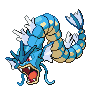

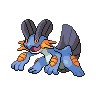

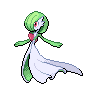

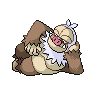

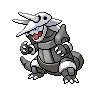

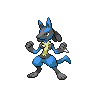

In [122]:
display_team(pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter)

In [121]:
display(pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter[["name","type1","type2"]])
display(present_solution_weaknesses(pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter, type_columns)[["min_val", "min_pkmn", "type1", "type2"]])

,name,type1,type2
129,gyarados,water,flying
243,swampert,water,ground
265,gardevoir,psychic,fairy
272,slaking,normal,NaN
289,aggron,steel,rock
411,lucario,fighting,steel


name,min_val,min_pkmn,type1,type2
against_bug,0.25,lucario,fighting,steel
against_dark,0.50,lucario,fighting,steel
against_dragon,0.00,gardevoir,psychic,fairy
against_electric,0.00,swampert,water,ground
against_fairy,0.50,aggron,steel,rock
against_fight,0.25,gardevoir,psychic,fairy
against_fire,0.50,gyarados,water,flying
against_flying,0.25,aggron,steel,rock
against_ghost,0.00,slaking,normal,NaN
against_grass,0.50,lucario,fighting,steel


**Perfect**! We finally have a team which can resist every possible encounter and is made of achievable Pokemon! Out of curiosity, let's just look at the various generations restrictions.

Out code: 1


None

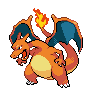

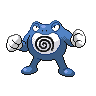

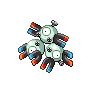

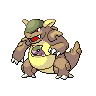

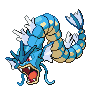

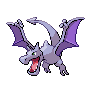

In [123]:
pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter_gen1 = optimize_team_weakness_improved_starter_cst(pks_no_legendaries_no_dragons_no_pl.loc[pks_no_legendaries_no_dragons_no_pl["generation"] <= 1], type_columns)
display_team(pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter_gen1)

Out code: 1


None

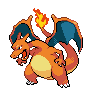

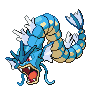

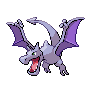

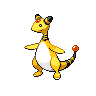

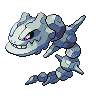

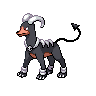

In [124]:
pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter_gen2 = optimize_team_weakness_improved_starter_cst(pks_no_legendaries_no_dragons_no_pl.loc[pks_no_legendaries_no_dragons_no_pl["generation"] <= 2], type_columns)
display_team(pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter_gen2)

Out code: 1


None

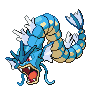

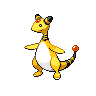

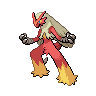

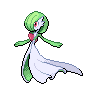

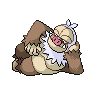

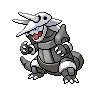

In [125]:
pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter_gen3 = optimize_team_weakness_improved_starter_cst(pks_no_legendaries_no_dragons_no_pl.loc[pks_no_legendaries_no_dragons_no_pl["generation"] <= 3], type_columns)
display_team(pkmns_weakness_optimized_nolegendaries_nodragons_nopl_starter_gen3)